# Introduction to MMOT with Pairwise Costs

In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

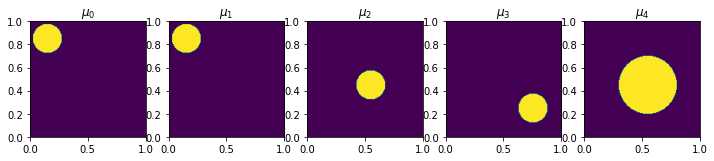

In [2]:
# Grid of size n1 x n2
n1 = 150   # x axis
n2 = 150   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

r = 0.125

# positions = np.array([[0.25,0.75],
#                       [0.5, 0.75],
#                       [ 0.55,0.35],
#                       [0.65,0.25]])

positions = np.array([[0.15,0.85],
                      [ 0.15,0.85],
                      [0.55,0.45],
                      [0.75,0.25]])

# measures = [None]*len(positions)
measures = [None]*(len(positions) +1 )

for i in range(len(positions)):
    xc,yc = positions[i]
    measures[i] = np.zeros((n2, n1))
    measures[i][(x-xc)**2 + (y-yc)**2 < r**2] = 1

    # Normalize
    measures[i] *= n1*n2 / np.sum(measures[i])

measures[4] = np.zeros((n2, n1))
measures[4][(x-positions[2][0])**2 + (y-positions[2][1])**2 < 4*r**2] = 1
measures[4] *= n1*n2 /np.sum(measures[4])


# Plot mu and nu
# fig, ax = plt.subplots(1, len(positions), figsize=(12,4))
# for i in range(len(positions)):
#   ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1))
#   ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

fig, ax = plt.subplots(1, len(measures), figsize=(12,4))
for i in range(len(measures)):
    ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1))
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

0


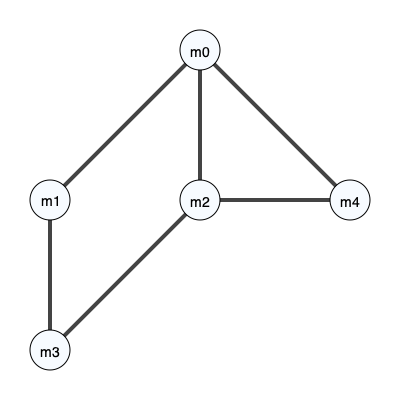

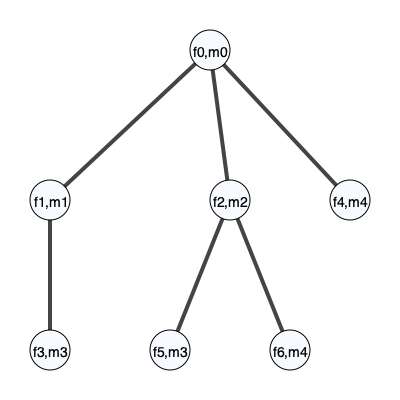

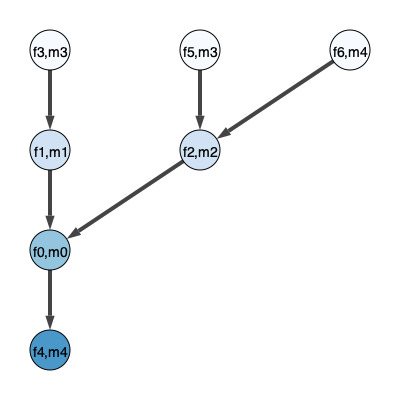

In [3]:
unroll_node = 0

# The set A that defines the pairwise costs
# edge_list = [[0,1],
#              [0,2],
#              [1,3],
#              [2,3]]
edge_list = [[0,1],
             [0,2],
             [1,3],
             [2,3],
             [0,4],
             [2,4]]


prob = MMOTSolver(measures, edge_list, x, y, unroll_node)

prob.Visualize('original', filename='CostGraph.svg')
prob.Visualize(filename='UndirectedTree.svg')
prob.Visualize(4,filename='DirectedTree.svg')

Iteration, StepSize,    Cost,     Error,  Line Its
        0,   0.2000,  0.4249,   3.23370,         0
        1,   0.2000,  0.6032,   2.62647,         0
        2,   0.2000,  0.6337,   1.10339,         0
        3,   0.2000,  0.6505,   0.89204,         0
        4,   0.2000,  0.6708,   0.81257,         0
        5,   0.2000,  0.6866,   0.52587,         0
        6,   0.2000,  0.6968,   0.30341,         0
        7,   0.2000,  0.7026,   0.26876,         0
        8,   0.2000,  0.7092,   0.24338,         0
        9,   0.2000,  0.7094,   0.29260,         1
       10,   0.2000,  0.7119,   0.28531,         2
       11,   0.2000,  0.7133,   0.13560,         0
       12,   0.2000,  0.7227,   0.19643,         1
       13,   0.2000,  0.7245,   0.07101,         1
       14,   0.2000,  0.7248,   0.04668,         1
       15,   0.2000,  0.7249,   0.03867,         1
       16,   0.2000,  0.7262,   0.04858,         2
       17,   0.2000,  0.7269,   0.01857,         2
       18,   0.2000,  0.7272,  

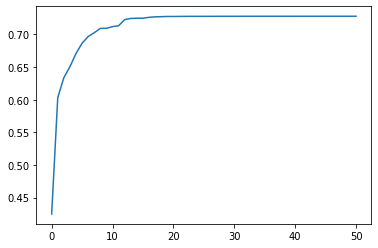

In [4]:
dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

num_its = 100
step_size = 0.2
ftol = 0.0
gtol = 1e-4
root_node = 3
costs = np.nan*np.zeros(num_its)

root_nodes = np.arange(prob.NumDual())
root_cycler = itertools.cycle(root_nodes)
old_cost = prob.ComputeCost(dual_vars)

print('Iteration, StepSize,    Cost,     Error,  Line Its')
for i in range(num_its):


    alpha = 1.0 
    line_it = 0
    max_line_its = 20
    while(line_it<max_line_its):
        new_duals = np.copy(dual_vars)
        error = prob.Step(next(root_cycler), new_duals, alpha*step_size)
        new_cost = prob.ComputeCost(new_duals)

        print(new_cost, ' vs ', old_cost, ' and ', old_cost +1e-4*error)
        if(new_cost>=old_cost+1e-4*error):
            costs[i] = new_cost 
            old_cost = np.copy(new_cost)
            dual_vars = np.copy(new_duals)
            break
        else:
            alpha *=0.5
            
        line_it += 1

    if(line_it>=max_line_its):
        print('Terminating due to failed line search.')
        break 
    #if(i>0):
    #    step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

    if((i%1)==0):
        print('{:9d},   {:0.4f},  {:0.4f},   {:0.5f},  {:8d}'.format(i,step_size, costs[i], error, line_it))

    # Check for convergence in cost
    if(np.abs(costs[i]-costs[i-1])<ftol):
        print('Terminating due to small change in objective.')
        break

    # Check for convergence via gradient 
    if(error<gtol):
        print('Terminating due to small gradient norm.')
        break 
        
plt.plot(costs)
plt.show()